In [4]:
import sys
sys.path.insert(1, '/home/thomas/research/repositories/xing-vimentin-dic-pipeline/src/memes/')

import warnings
warnings.filterwarnings("ignore")

import glob
import math
import numpy as np
import os
import random

import matplotlib.pyplot as plt
from scipy.ndimage import binary_fill_holes as fill_holes
from skimage.io import imread

from black_border_remove import main as bbr
import hj_util
from pilutil import toimage

In [5]:
main_path = hj_util.folder_verify('/home/thomas/research/projects/a549_40x/data/train/reg/')
label_path = hj_util.folder_verify(main_path + 'seg/a549_vim_rfp_control_091621/')
patch_path = hj_util.folder_verify(main_path + 'patch/purity_thres_07/')

im_num = len(glob.glob(label_path + '*crop*'))

# patch_size
# round to 32 times
train_patch_w=224
train_patch_h=224

test_patch_w=224
test_patch_h=224

#---crop a image by several times to increase samples
patch_copy=5
patch_purity_thres=0.07
patch_trial_thres=100

In [ ]:
#generate regression and mask train_test data=patch_path+'bib/'
train_bib_path=patch_path+'bib/'
hj_util.create_folder(train_bib_path)

train_boundary_path=patch_path+'boundary/'
hj_util.create_folder(train_boundary_path)

train_reg_path=patch_path+'bwdist/'
hj_util.create_folder(train_reg_path)

train_img_path=patch_path+'img/'
hj_util.create_folder(train_img_path) 

train_interior_path=patch_path+'interior/'
hj_util.create_folder(train_interior_path) 

In [7]:
#random crop image into patches
bib_str=sorted(glob.glob(label_path+ "BIB*.png"))
boundary_str=sorted(glob.glob(label_path+ "boundary*.png"))
bwdist_str=sorted(glob.glob(label_path+ "bwdist*.png"))
img_str=sorted(glob.glob(label_path+ "crop*.png"))
interior_str=sorted(glob.glob(label_path+ "interior*.png"))

In [ ]:
train_patch_count=0

for ti in np.arange(len(img_str)):
    
#     bib      = imread(bib_str[ti])
    boundary = imread(boundary_str[ti])
    bwdist   = imread(bwdist_str[ti])
    img      = imread(img_str[ti])
    interior = imread(interior_str[ti])
    
    img, removed_cols, removed_rows = bbr(img) # sometimes the images captured by the nikon microscope has black borders
#     bib = np.delete(bib,removed_rows,axis=0); bib = np.delete(bib,removed_cols,axis=1)
    boundary = np.delete(boundary,removed_rows,axis=0); boundary = np.delete(boundary,removed_cols,axis=1)
    bwdist = np.delete(bwdist,removed_rows,axis=0); bwdist = np.delete(bwdist,removed_cols,axis=1)
    interior = np.delete(interior,removed_rows,axis=0); interior = np.delete(interior,removed_cols,axis=1)
    
    interior = fill_holes(interior)*1 # This should be done in Matlab if possible
    boundary = boundary*(interior==0)*1
    bib = interior + (boundary*2)
    
    img_w, img_h = img_h, img_w = img.shape[0], img.shape[1]
    if img_w < train_patch_w or img_h < train_patch_h:
        ti = ti+1
        continue
    
    purity = np.sum((interior!=0)*1)/interior.size
    n_patch = round(purity*(img_w/train_patch_w)*(img_h/train_patch_h)*patch_copy)
    print('currently cropping '+os.path.basename(img_str[ti]))
#     print('    crop purity: '+str(purity)+', target patch number: '+ str(n_patch))
    
    i=0
    while i<n_patch:
        
        k=0
        while k<patch_trial_thres:
            xmin=round(random.uniform(0, 1)*(img_w-train_patch_w))
            ymin=round(random.uniform(0, 1)*(img_h-train_patch_h))

            patch_bib=bib[ymin:ymin+train_patch_h, xmin:xmin+train_patch_w]
            patch_boundary=boundary[ymin:ymin+train_patch_h, xmin:xmin+train_patch_w]
            patch_bwdist=bwdist[ymin:ymin+train_patch_h, xmin:xmin+train_patch_w]
            patch_img=img[ymin:ymin+train_patch_h, xmin:xmin+train_patch_w]
            patch_interior=interior[ymin:ymin+train_patch_h, xmin:xmin+train_patch_w]

            patch_purity = np.sum((patch_interior!=0)*1)/patch_interior.size
#             print('        patch #'+str(i+1), ', take '+str(k+1), ', patch purity: '+str(patch_purity))

            if patch_purity < patch_purity_thres:
                k += 1
                if k == patch_trial_thres:
                    i = n_patch
            else:
                patch_bib = toimage(patch_bib)
                patch_bib.save(train_bib_path+str(train_patch_count)+'.png')
                patch_boundary = toimage(patch_boundary)
                patch_boundary.save(train_boundary_path+str(train_patch_count)+'.png')
                patch_bwdist = toimage(patch_bwdist)
                patch_bwdist.save(train_reg_path+str(train_patch_count)+'.png')
                patch_img = toimage(patch_img)
                patch_img.save(train_img_path+str(train_patch_count)+'.png')
                patch_interior = toimage(patch_interior)
                patch_interior.save(train_interior_path+str(train_patch_count)+'.png')

                train_patch_count+=1
                k = patch_trial_thres
                i+=1        

# look at the pictures generated

In [56]:
def folder_img_show(folder):
    
    """
    A convient function for print pictures under a folder.
    20 pics at a time.
    """
    fig = plt.figure(figsize=(20, 20))
    img_path_list = glob.glob(folder + "/*")
    
    if len(img_path_list)<20:
        print("Not enough pictures to print")
        return 1
    
    for i,img_path in enumerate(img_path_list[:20]):
        fig.add_subplot(4,5, i+1)
        plt.imshow(imread(img_path)/256.)

    plt.show()

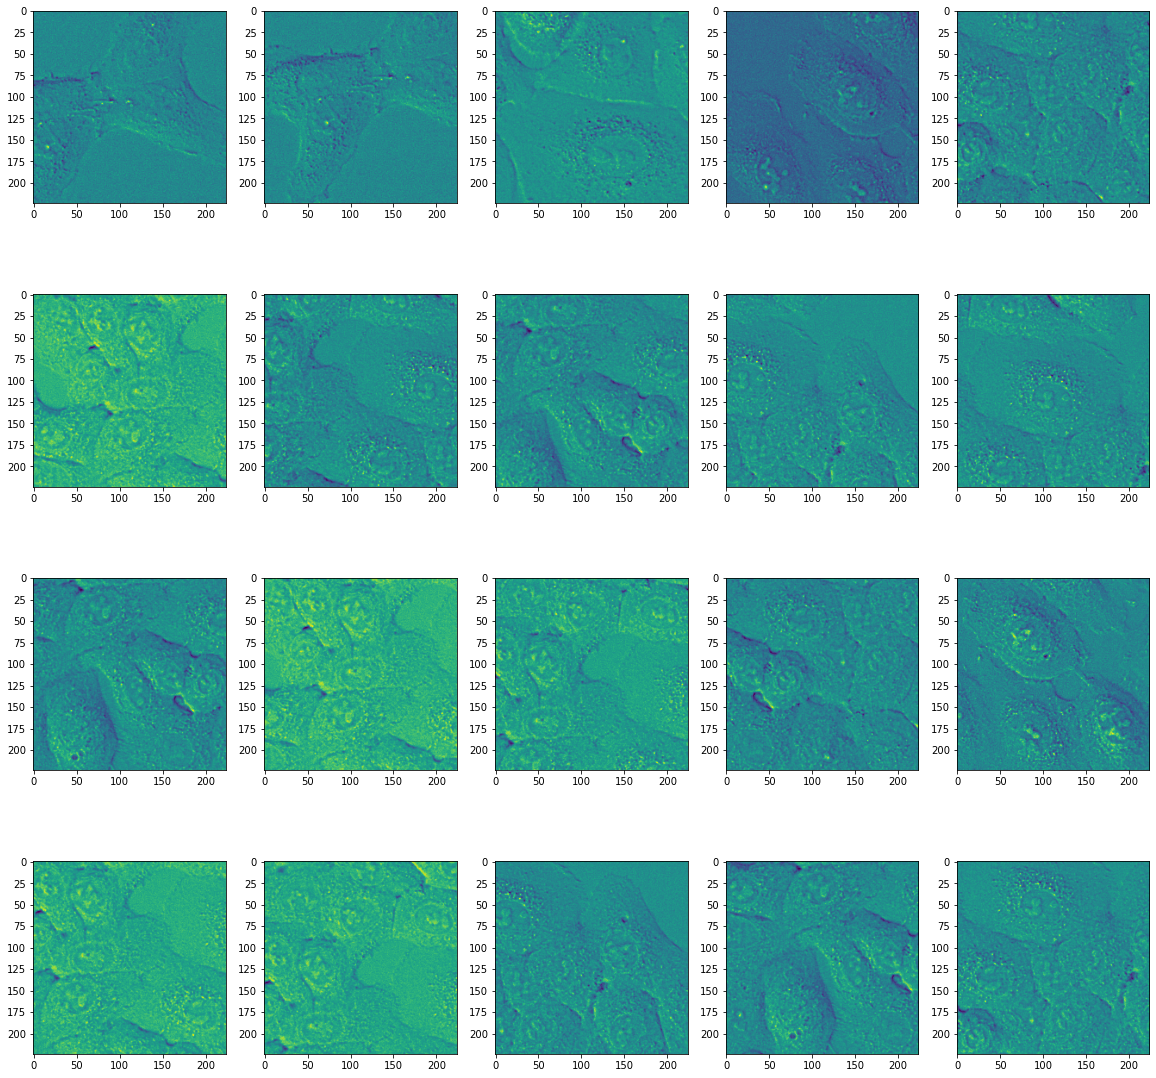

In [57]:
folder_img_show(train_img_path)

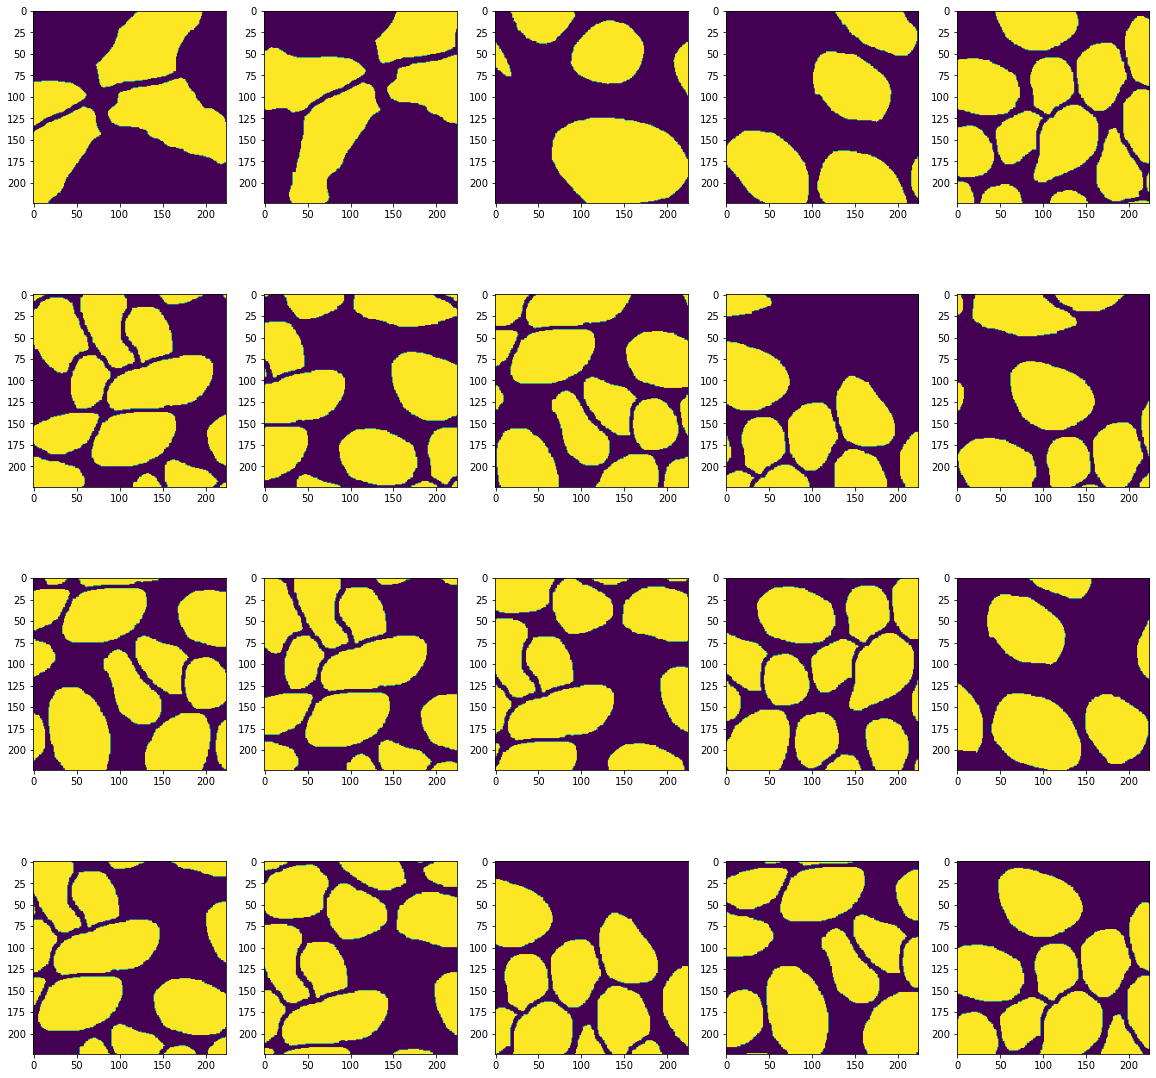

In [58]:
folder_img_show(train_interior_path)

# check crop folder confluency

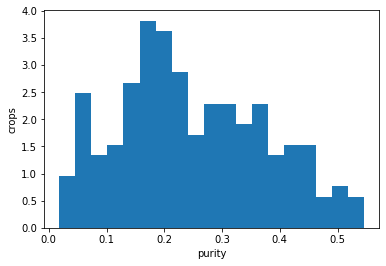

In [60]:
purity_index = np.zeros(len(img_str))
for img_idx in range(len(img_str)):
    interior = imread(interior_str[img_idx])
    purity = np.sum((interior!=0)*1)/interior.size
    purity_index[img_idx] = purity
n_bin = math.ceil(len(img_str)/10)
plt.hist(purity_index, density=True, bins=n_bin)  # density=False would make counts
plt.ylabel('crops')
plt.xlabel('purity');